# Proyecto Final
## Elements of Machine Learning
## Carlos Morales Sanchez 20180067

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib

In [19]:
data = pd.read_csv("datos_premier_eml.csv")
print(data.shape)
data.head()

(7200, 21)


,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,...,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,Fulham,Arsenal,A,0,1,-1,2.5,6.5,1.0,3.0,...,6.0,1.0,1.5,1.0,1.0,0.0,0.0,6.00,4.33,1.53
1,Crystal Palace,Southampton,H,1,0,1,2.5,4.5,1.5,2.5,...,5.5,3.5,1.5,1.0,0.5,0.0,0.0,3.10,3.25,2.37
2,Liverpool,Leeds,H,3,2,1,11.0,3.0,3.0,1.5,...,3.0,4.5,0.0,0.5,0.0,0.0,0.0,1.28,6.00,9.50
3,West Ham,Newcastle,A,0,0,0,7.5,7.5,1.5,1.0,...,3.5,4.0,3.5,1.0,1.0,0.0,0.0,2.15,3.40,3.40
4,West Brom,Leicester,A,0,0,0,3.5,6.5,0.5,3.5,...,4.5,1.0,2.5,0.5,0.5,0.0,0.0,3.80,3.60,1.95


El dataset cuenta con registro de cada partido que se ha disputado en la Liga Premier de Inglaterra desde la temporada 2003/2004 hasta la fecha. El dataset se consolidó utilizando los documentos que publica Football-data cada año. Fuente: http://www.football-data.co.uk/englandm.php

El objetivo general del proyecto consiste en predecir la variable FTR (Full time result), la cual puede tomar 3 valores: A (victoria del visitant) D (empate) H (victoria del local), utilizando como input el resto de variables del dataset, con información corresponidente a las estadisticas de juego generadas por cada equipo (tiros, faltas, tarjetas, tiros de esquina), y el monto que paga Bet365 antes del comienzo del partido en apuestas por victoria local, visitante, o empate.

Como primer punto se generó un segundo dataset, el cual excluye las variables categóricas HomeTeam y AwayTeam, las cuales indican el nombre del equipo que jugaba. Esto con el fin de determinar si es mejor entrenar el modelo utilizando dichas variables o no. 

In [20]:
dataX = data.drop('FTR', axis = 'columns')
dataX2 = data.drop(['FTR','HomeTeam','AwayTeam'], axis = 'columns')
dataX.head()

,HomeTeam,AwayTeam,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,Fulham,Arsenal,0,1,-1,2.5,6.5,1.0,3.0,6.0,6.0,1.0,1.5,1.0,1.0,0.0,0.0,6.00,4.33,1.53
1,Crystal Palace,Southampton,1,0,1,2.5,4.5,1.5,2.5,7.0,5.5,3.5,1.5,1.0,0.5,0.0,0.0,3.10,3.25,2.37
2,Liverpool,Leeds,3,2,1,11.0,3.0,3.0,1.5,4.5,3.0,4.5,0.0,0.5,0.0,0.0,0.0,1.28,6.00,9.50
3,West Ham,Newcastle,0,0,0,7.5,7.5,1.5,1.0,6.5,3.5,4.0,3.5,1.0,1.0,0.0,0.0,2.15,3.40,3.40
4,West Brom,Leicester,0,0,0,3.5,6.5,0.5,3.5,6.0,4.5,1.0,2.5,0.5,0.5,0.0,0.0,3.80,3.60,1.95


Se realizó un onehot encoder para generar variables dummies de cada una de las categorias de HomeTeam y AwayTeam. 

In [21]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            df.drop([col],axis = 1 , inplace=True)
    return df

In [22]:
dataX = oneHotEncode(dataX,dataX.columns)
dataX.head()

,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,...,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,0,1,-1,2.5,6.5,1.0,3.0,6.0,6.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,2.5,4.5,1.5,2.5,7.0,5.5,3.5,...,1,0,0,0,0,0,0,0,0,0
2,3,2,1,11.0,3.0,3.0,1.5,4.5,3.0,4.5,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,7.5,7.5,1.5,1.0,6.5,3.5,4.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3.5,6.5,0.5,3.5,6.0,4.5,1.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
dataset = dataX.values
dataset2 = dataX2.values
data_v = data.values

De acuerdo a la documentación citada al final del notebook, se realizó un standard scaler a las variables numéricas, buscando un mejor resultado en el modelo. 

In [24]:
scaler = StandardScaler().fit(dataset)
scaler2 = StandardScaler().fit(dataset2)

dataset = scaler.transform(dataset)
dataset2 = scaler2.transform(dataset2)

Tambíen fue necesario generar variables dummies para la variable objetio (FTR) ya que dicha variable es categórica, y tiene 3 categorías. 

In [25]:
y = data_v[:,2]
y_0 = y[0:2000]
X = dataset
X_0 = dataset[0:2000]
X2 = dataset2
X2_0 = dataset2[0:2000]
print(X.shape)
print(X)
print(X2.shape)
print(X2)
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
y = np_utils.to_categorical(encoded_Y)
print(y.shape)
print(y)

(7200, 98)
[[-0.81941278  0.68664143 -1.04728995 ... -0.20959996 -0.14685504
  -0.13665914]
 [ 0.38290473 -0.70051297  0.73301642 ... -0.20959996 -0.14685504
  -0.13665914]
 [ 2.78753976  2.07379582  0.73301642 ... -0.20959996 -0.14685504
  -0.13665914]
 ...
 [ 2.78753976 -0.70051297  2.51332279 ... -0.20959996 -0.14685504
  -0.13665914]
 [ 2.78753976  0.68664143  1.6231696  ... -0.20959996 -0.14685504
  -0.13665914]
 [-0.81941278  0.68664143 -1.04728995 ... -0.20959996 -0.14685504
  -0.13665914]]
(7200, 18)
[[-0.81941278  0.68664143 -1.04728995 ...  1.71252156  0.35016326
  -0.82197336]
 [ 0.38290473 -0.70051297  0.73301642 ...  0.18893405 -0.60138829
  -0.61060593]
 [ 2.78753976  2.07379582  0.73301642 ... -0.76724846  1.82154389
   1.18350091]
 ...
 [ 2.78753976 -0.70051297  2.51332279 ... -0.33644096 -0.60138829
  -0.35142921]
 [ 2.78753976  0.68664143  1.6231696  ... -0.25763471 -0.55733497
  -0.45208036]
 [-0.81941278  0.68664143 -1.04728995 ... -0.19458971 -0.55733497
  -0.50240

In [26]:
np.random.seed(25)

Como primer punto se generan dos funciones, encargadas de generar la misma red neuronal, y de esta forma poder evaluar el dataset con variables dummies, y sin variables dummies. De esta forma se determinará que dataset se utilizará para seguir adelante con el modelo. 

In [27]:
def create_model():

    model = Sequential()
    model.add(Dense(12, input_dim=98, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
def create_model_2():

    model = Sequential()
    model.add(Dense(12, input_dim=18, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
estimator = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

In [30]:
estimator2 = KerasClassifier(build_fn=create_model_2, epochs=50, batch_size=5, verbose=0)

In [31]:
kfold = KFold(n_splits=10, shuffle=True)

In [32]:
results = cross_val_score(estimator, X_0, y_0, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 61.05% (5.35%)


In [33]:
results = cross_val_score(estimator2, X2_0, y_0, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 67.25% (2.21%)


Se determinó que las variables categóricas HomeTeam y Away team no aportan un verdadero valor al modelo predictivo realizado en esta prueba. Debido a esto se decidió trabajar con el dataset que no contiene dichas variables, puesto que estas perjudican la predicción, e incrementan el nivel de computo requerido. 

Posteriormente se utilizará la función de Grid Search, con el fin de probar multiples hiper parametros, como el optimizador utilizado, el estado inicial de los pesos de la red, el número de epochs y el bach size. De esta forma se determinará la mejor combinación, para pasar a la parte final en la cual se evaluará la arquitectura que debera tener la red. 

In [34]:
def create_model_3(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(12, input_dim = 18, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(3, kernel_initializer=init, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [35]:
model = KerasClassifier(build_fn=create_model_3, verbose=0)

In [36]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100]
batches = [5, 10, 20]


In [37]:
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X2_0, y_0)

print("Ideal: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Ideal: 0.673500 using {'batch_size': 20, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.655500 (0.030307) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.649000 (0.021599) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.661000 (0.023484) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.657500 (0.025000) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.653500 (0.034807) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.660000 (0.035637) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.640000 (0.031544) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.643500 (0.022616) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.640500 (0.033556) with: {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'o

Como se observa anteriormente, el modelo que obtuvo el mejor resultado de accuracy fue el que utilizó un batch size de 20, un total de 50 epochs, inicializador 'normal', y optimizador 'rmsprop'

Para la parte final de selección, se dividó el dataset en 3 fragmentos. El 70% para entrenamiento del modelo, 20% para testeo continuo, y 10 para cross validation en la parte final. Esto se realiza para asegurarnos de que el modelo no este generando overfitting, y perdiendo su capacidad de geeralizar. 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=15)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=15)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(5040, 18)
(5040, 3)
(1447, 18)
(1447, 3)
(713, 18)
(713, 3)


Para seleecioanr la mejor arquitectura de red neural para el modelo, se comenzó utilizando una base con estructura 12/8/3. El objetivo es ir movinedonos desde aqui, hasta llegar a la estructura que mejor resultado genere. La red neuronal utiliza los parámetos previamente identificados como los mejores, además de la función de activación relu para las capas oculats, y softmax para la capa de output. También se utilizó categorical crossentropy como la loss functio que el modelo optimizará.

A continuación se observara una gran serie de modelos de redes neuronales, cada uno con una arquitectura distinta, con el fin de determianr que estructura se utilizará para el modelo definitivo.

In [39]:
model = Sequential()

model.add(Dense(12, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_663 (Dense)            (None, 12)                228       
_________________________________________________________________
dense_664 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_665 (Dense)            (None, 3)                 27        
Total params: 359
Trainable params: 359
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0127 - accuracy: 0.5418
Epoch 2/200
252/252 [==============================] - 0s 982us/step - loss: 0.7628 - accuracy: 0.6479
Epoch 3/200
252/252 [==============================] - 0s 946us/step - loss: 0.7466 - accuracy: 0.6522
Epoch 4/200
252/252 [==============================] - 0s 943us/step - loss: 0.7458 - accuracy: 0.6578
Epoch 5/200
252/252 [==============================] - 0s 949us/step - loss: 0.7317 - accuracy: 0.6700
Epoch 6/200
252/252 [==============================] - 0s 952us/step - loss: 0.7346 - accuracy: 0.6614
Epoch 7/200
252/252 [==============================] - 0s 938us/step - loss: 0.7313 - accuracy: 0.6703
Epoch 8/200
252/252 [==============================] - 0s 948us/step - loss: 0.7197 - accuracy: 0.6666
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7279 - accuracy: 0.6626
Epoch 10/200
252/252 [==============================] - 0s 977us/step - loss:

In [42]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 950us/step - loss: 0.8036 - accuracy: 0.6289
Acc:
0.6288873553276062


In [43]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_666 (Dense)            (None, 14)                266       
_________________________________________________________________
dense_667 (Dense)            (None, 8)                 120       
_________________________________________________________________
dense_668 (Dense)            (None, 3)                 27        
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 979us/step - loss: 1.0216 - accuracy: 0.5143
Epoch 2/200
252/252 [==============================] - 0s 996us/step - loss: 0.7600 - accuracy: 0.6464
Epoch 3/200
252/252 [==============================] - 0s 988us/step - loss: 0.7382 - accuracy: 0.6500
Epoch 4/200
252/252 [==============================] - 0s 999us/step - loss: 0.7286 - accuracy: 0.6657
Epoch 5/200
252/252 [==============================] - 0s 947us/step - loss: 0.7420 - accuracy: 0.6562
Epoch 6/200
252/252 [==============================] - 0s 964us/step - loss: 0.7406 - accuracy: 0.6527
Epoch 7/200
252/252 [==============================] - 0s 949us/step - loss: 0.7283 - accuracy: 0.6546
Epoch 8/200
252/252 [==============================] - 0s 948us/step - loss: 0.7088 - accuracy: 0.6763
Epoch 9/200
252/252 [==============================] - 0s 964us/step - loss: 0.7253 - accuracy: 0.6592
Epoch 10/200
252/252 [==============================] - 0s 961us/step - l

In [46]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 857us/step - loss: 0.8117 - accuracy: 0.6296
Acc:
0.6295784115791321


In [47]:
model = Sequential()

model.add(Dense(10, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))
model.summary()

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_669 (Dense)            (None, 10)                190       
_________________________________________________________________
dense_670 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_671 (Dense)            (None, 3)                 27        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0382 - accuracy: 0.4988
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7851 - accuracy: 0.6583
Epoch 3/200
252/252 [==============================] - 0s 983us/step - loss: 0.7550 - accuracy: 0.6451
Epoch 4/200
252/252 [==============================] - 0s 947us/step - loss: 0.7384 - accuracy: 0.6594
Epoch 5/200
252/252 [==============================] - 0s 940us/step - loss: 0.7302 - accuracy: 0.6568
Epoch 6/200
252/252 [==============================] - 0s 965us/step - loss: 0.7326 - accuracy: 0.6609
Epoch 7/200
252/252 [==============================] - 0s 950us/step - loss: 0.7193 - accuracy: 0.6638
Epoch 8/200
252/252 [==============================] - 0s 946us/step - loss: 0.7252 - accuracy: 0.6616
Epoch 9/200
252/252 [==============================] - 0s 947us/step - loss: 0.7246 - accuracy: 0.6647
Epoch 10/200
252/252 [==============================] - 0s 970us/step - loss:

In [50]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 823us/step - loss: 0.7871 - accuracy: 0.6406
Acc:
0.6406357884407043


In [51]:
model = Sequential()

model.add(Dense(12, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_672 (Dense)            (None, 12)                228       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_673 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_674 (Dense)            (None, 3)                 27        
Total params: 359
Trainable params: 359
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 993us/step - loss: 1.0385 - accuracy: 0.5105
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7882 - accuracy: 0.6454
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7744 - accuracy: 0.6462
Epoch 4/200
252/252 [==============================] - 0s 976us/step - loss: 0.7610 - accuracy: 0.6525
Epoch 5/200
252/252 [==============================] - 0s 970us/step - loss: 0.7516 - accuracy: 0.6490
Epoch 6/200
252/252 [==============================] - 0s 963us/step - loss: 0.7313 - accuracy: 0.6671
Epoch 7/200
252/252 [==============================] - 0s 974us/step - loss: 0.7399 - accuracy: 0.6548
Epoch 8/200
252/252 [==============================] - 0s 973us/step - loss: 0.7532 - accuracy: 0.6608
Epoch 9/200
252/252 [==============================] - 0s 976us/step - loss: 0.7516 - accuracy: 0.6535
Epoch 10/200
252/252 [==============================] - 0s 973us/step - loss:

In [54]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 890us/step - loss: 0.7714 - accuracy: 0.6365
Acc:
0.6364892721176147


In [55]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_675 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_676 (Dense)            (None, 8)                 120       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_677 (Dense)            (None, 3)                 27        
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [57]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 989us/step - loss: 1.0501 - accuracy: 0.4882
Epoch 2/200
252/252 [==============================] - 0s 995us/step - loss: 0.8441 - accuracy: 0.5792
Epoch 3/200
252/252 [==============================] - 0s 990us/step - loss: 0.7987 - accuracy: 0.6496
Epoch 4/200
252/252 [==============================] - 0s 981us/step - loss: 0.7884 - accuracy: 0.6588
Epoch 5/200
252/252 [==============================] - 0s 997us/step - loss: 0.7912 - accuracy: 0.6528
Epoch 6/200
252/252 [==============================] - 0s 985us/step - loss: 0.7842 - accuracy: 0.6586
Epoch 7/200
252/252 [==============================] - 0s 984us/step - loss: 0.7834 - accuracy: 0.6611
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7768 - accuracy: 0.6669
Epoch 9/200
252/252 [==============================] - 0s 974us/step - loss: 0.7826 - accuracy: 0.6510
Epoch 10/200
252/252 [==============================] - 0s 978us/step - los

In [58]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 1s 854us/step - loss: 0.7865 - accuracy: 0.6358
Acc:
0.6357982158660889


In [59]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_678 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_3 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_679 (Dense)            (None, 10)                150       
_________________________________________________________________
dense_680 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_681 (Dense)            (None, 3)                 27        
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [61]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0713 - accuracy: 0.4901
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.8172 - accuracy: 0.6517
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7562 - accuracy: 0.6576
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7576 - accuracy: 0.6582
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7461 - accuracy: 0.6646
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7430 - accuracy: 0.6652
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7426 - accuracy: 0.6639
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7466 - accuracy: 0.6548
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7485 - accuracy: 0.6615
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7451 - accura

In [62]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 832us/step - loss: 0.7667 - accuracy: 0.6413
Acc:
0.641326904296875


In [63]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_682 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_683 (Dense)            (None, 12)                180       
_________________________________________________________________
dense_684 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_685 (Dense)            (None, 3)                 27        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [65]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0266 - accuracy: 0.4749
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.8428 - accuracy: 0.6433
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7832 - accuracy: 0.6517
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7507 - accuracy: 0.6561
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7585 - accuracy: 0.6496
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7416 - accuracy: 0.6618
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.6781
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7523 - accuracy: 0.6551
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7656 - accuracy: 0.6484
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7475 - accura

In [66]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 815us/step - loss: 0.7773 - accuracy: 0.6393
Acc:
0.6392536163330078


In [67]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_686 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_687 (Dense)            (None, 12)                180       
_________________________________________________________________
dense_688 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_689 (Dense)            (None, 3)                 39        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [69]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0326 - accuracy: 0.5088
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7697 - accuracy: 0.6472
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7488 - accuracy: 0.6511
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7444 - accuracy: 0.6605
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7416 - accuracy: 0.6586
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.6627
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7441 - accuracy: 0.6660
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7485 - accuracy: 0.6643
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7487 - accuracy: 0.6641
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7343 - accura

In [70]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 822us/step - loss: 0.7690 - accuracy: 0.6413
Acc:
0.641326904296875


In [71]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_690 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_6 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_691 (Dense)            (None, 12)                180       
_________________________________________________________________
dense_692 (Dense)            (None, 14)                182       
_________________________________________________________________
dense_693 (Dense)            (None, 3)                 45        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [73]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0196 - accuracy: 0.4891
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7788 - accuracy: 0.6540
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.6655
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7510 - accuracy: 0.6664
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7378 - accuracy: 0.6686
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7321 - accuracy: 0.6688
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7494 - accuracy: 0.6578
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7525 - accuracy: 0.6641
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7377 - accuracy: 0.6685
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7312 - accura

In [74]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 817us/step - loss: 0.7712 - accuracy: 0.6399
Acc:
0.6399447321891785


In [75]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_694 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_7 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_695 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_696 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_697 (Dense)            (None, 3)                 45        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0262 - accuracy: 0.5054
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7783 - accuracy: 0.6454
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7429 - accuracy: 0.6626
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7537 - accuracy: 0.6542
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7473 - accuracy: 0.6597
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7450 - accuracy: 0.6712
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7462 - accuracy: 0.6606
Epoch 8/200
252/252 [==============================] - 0s 982us/step - loss: 0.7396 - accuracy: 0.6663
Epoch 9/200
252/252 [==============================] - 0s 995us/step - loss: 0.7423 - accuracy: 0.6666
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7413 - ac

In [78]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 811us/step - loss: 0.7762 - accuracy: 0.6344
Acc:
0.6344160437583923


In [79]:
model = Sequential()

model.add(Dense(14, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_698 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_8 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_699 (Dense)            (None, 14)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_700 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_701 (Dense)            (None, 3)                 45        
Total params: 731
Trainable params: 731
Non-trainable params: 0
______________________________________________________

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [81]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0384 - accuracy: 0.4905
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7945 - accuracy: 0.6454
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7523 - accuracy: 0.6636
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7822 - accuracy: 0.6528
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7491 - accuracy: 0.6710
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7513 - accuracy: 0.6682
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7620 - accuracy: 0.6568
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7549 - accuracy: 0.6719
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7407 - accuracy: 0.6696
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7558 - accura

In [82]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 908us/step - loss: 0.7859 - accuracy: 0.6455
Acc:
0.6454734206199646


In [83]:
model = Sequential()

model.add(Dense(16, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_702 (Dense)            (None, 16)                304       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_703 (Dense)            (None, 14)                238       
_________________________________________________________________
dropout_11 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_704 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_705 (Dense)            (None, 3)                 45        
Total params: 797
Trainable params: 797
Non-trainable params: 0
______________________________________________________

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [85]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0276 - accuracy: 0.5035
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7972 - accuracy: 0.6425
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7654 - accuracy: 0.6505
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7450 - accuracy: 0.6621
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7521 - accuracy: 0.6677
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7580 - accuracy: 0.6617
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7594 - accuracy: 0.6607
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.6718
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7435 - accuracy: 0.6693
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7322 - accura

In [86]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 1s 829us/step - loss: 0.7953 - accuracy: 0.6220
Acc:
0.6219764947891235


In [87]:
model = Sequential()

model.add(Dense(16, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_706 (Dense)            (None, 16)                304       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_707 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_708 (Dense)            (None, 14)                238       
_________________________________________________________________
dense_709 (Dense)            (None, 3)                 45        
Total params: 859
Trainable params: 859
Non-trainable params: 0
______________________________________________________

In [88]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [89]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0182 - accuracy: 0.5011
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.8242 - accuracy: 0.6507
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7670 - accuracy: 0.6587
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7567 - accuracy: 0.6579
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7541 - accuracy: 0.6628
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7716 - accuracy: 0.6488
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7617 - accuracy: 0.6610
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7417 - accuracy: 0.6577
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7531 - accuracy: 0.6715
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7474 - accura

In [90]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 802us/step - loss: 0.7979 - accuracy: 0.6379
Acc:
0.6378714442253113


In [91]:
model = Sequential()

model.add(Dense(16, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_710 (Dense)            (None, 16)                304       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_711 (Dense)            (None, 14)                238       
_________________________________________________________________
dropout_15 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_712 (Dense)            (None, 10)                150       
_________________________________________________________________
dense_713 (Dense)            (None, 3)                 33        
Total params: 725
Trainable params: 725
Non-trainable params: 0
______________________________________________________

In [92]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [93]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0295 - accuracy: 0.5018
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7894 - accuracy: 0.6494
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7590 - accuracy: 0.6579
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7546 - accuracy: 0.6608
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7493 - accuracy: 0.6590
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7641 - accuracy: 0.6586
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7689 - accuracy: 0.6483
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7465 - accuracy: 0.6639
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7435 - accuracy: 0.6587
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7382 - accura

In [94]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 2ms/step - loss: 0.7764 - accuracy: 0.6441
Acc:
0.6440912485122681


In [95]:
model = Sequential()

model.add(Dense(16, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_714 (Dense)            (None, 16)                304       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_715 (Dense)            (None, 14)                238       
_________________________________________________________________
dropout_17 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_716 (Dense)            (None, 8)                 120       
_________________________________________________________________
dense_717 (Dense)            (None, 3)                 27        
Total params: 689
Trainable params: 689
Non-trainable params: 0
______________________________________________________

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [97]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0335 - accuracy: 0.5257
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7873 - accuracy: 0.6481
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7757 - accuracy: 0.6452
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7563 - accuracy: 0.6607
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7430 - accuracy: 0.6705
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7458 - accuracy: 0.6728
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7505 - accuracy: 0.6535
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7418 - accuracy: 0.6658
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7584 - accuracy: 0.6626
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7467 - accura

In [98]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 918us/step - loss: 0.7776 - accuracy: 0.6337
Acc:
0.6337249279022217


In [99]:
model = Sequential()

model.add(Dense(18, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_718 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_18 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_719 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_19 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_720 (Dense)            (None, 10)                150       
_________________________________________________________________
dense_721 (Dense)            (None, 3)                 33        
Total params: 791
Trainable params: 791
Non-trainable params: 0
______________________________________________________

In [100]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [101]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0504 - accuracy: 0.4863
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7773 - accuracy: 0.6546
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7769 - accuracy: 0.6389
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7559 - accuracy: 0.6610
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7610 - accuracy: 0.6594
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7763 - accuracy: 0.6447
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7478 - accuracy: 0.6690
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7477 - accuracy: 0.6589
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7440 - accuracy: 0.6610
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7347 - accura

In [102]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 790us/step - loss: 0.7766 - accuracy: 0.6455
Acc:
0.6454734206199646


In [103]:
model = Sequential()

model.add(Dense(24, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_722 (Dense)            (None, 24)                456       
_________________________________________________________________
dropout_20 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_723 (Dense)            (None, 14)                350       
_________________________________________________________________
dropout_21 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_724 (Dense)            (None, 8)                 120       
_________________________________________________________________
dense_725 (Dense)            (None, 3)                 27        
Total params: 953
Trainable params: 953
Non-trainable params: 0
______________________________________________________

In [104]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [105]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0353 - accuracy: 0.4518
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.8544 - accuracy: 0.6482
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7750 - accuracy: 0.6501
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7607 - accuracy: 0.6577
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7619 - accuracy: 0.6571
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7470 - accuracy: 0.6588
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7475 - accuracy: 0.6559
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7505 - accuracy: 0.6579
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7597 - accuracy: 0.6505
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7463 - accura

In [106]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 980us/step - loss: 0.7842 - accuracy: 0.6323
Acc:
0.6323427557945251


In [107]:
model = Sequential()

model.add(Dense(18, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_726 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_22 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_727 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_23 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_728 (Dense)            (None, 8)                 120       
_________________________________________________________________
dense_729 (Dense)            (None, 6)                 54        
_________________________________________________________________
dense_730 (Dense)            (None, 3)              

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [109]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 1s 1ms/step - loss: 1.0892 - accuracy: 0.4568
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 1.0658 - accuracy: 0.4644
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.9151 - accuracy: 0.6327
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7748 - accuracy: 0.6620
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7783 - accuracy: 0.6425
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7649 - accuracy: 0.6475
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7694 - accuracy: 0.6562
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7443 - accuracy: 0.6667
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7678 - accuracy: 0.6484
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7362 - accura

In [110]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 1ms/step - loss: 0.7915 - accuracy: 0.6213
Acc:
0.6212854385375977


In [111]:
model = Sequential()

model.add(Dense(18, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_731 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_24 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_732 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_25 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_733 (Dense)            (None, 8)                 120       
_________________________________________________________________
dropout_26 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_734 (Dense)            (None, 6)              

In [112]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [113]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, verbose=1)

Epoch 1/200
252/252 [==============================] - 2s 1ms/step - loss: 1.0509 - accuracy: 0.4682
Epoch 2/200
252/252 [==============================] - 0s 1ms/step - loss: 0.8378 - accuracy: 0.6438
Epoch 3/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7678 - accuracy: 0.6686
Epoch 4/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7577 - accuracy: 0.6574
Epoch 5/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7585 - accuracy: 0.6584
Epoch 6/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7784 - accuracy: 0.6506
Epoch 7/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7808 - accuracy: 0.6505
Epoch 8/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7490 - accuracy: 0.6669
Epoch 9/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7718 - accuracy: 0.6502
Epoch 10/200
252/252 [==============================] - 0s 1ms/step - loss: 0.7644 - accura

In [114]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 850us/step - loss: 0.7897 - accuracy: 0.6420
Acc:
0.6420179605484009


Finalmente, y tras ejecutar multiples veces cada opción de arquitectura, se determinó que el modelo más adecuado es el de la estructura 18/14/10/3, con dropout de 0.3 en la primera y la segunda capa. Para determinar que este fue el mejor modelo, se reviso cuidadosamente el accuracy que obtenia con el dataset de testeo, ya que de esta forma nos aseguramos que no se trate solamente de un caso de overfiting.

In [115]:
model = Sequential()

model.add(Dense(18, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_736 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_27 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_737 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_28 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_738 (Dense)            (None, 10)                150       
_________________________________________________________________
dense_739 (Dense)            (None, 3)                 33        
Total params: 791
Trainable params: 791
Non-trainable params: 0
______________________________________________________

In [116]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [117]:
history = model.fit(X_train, y_train, epochs=500, batch_size=20, verbose=1)

Epoch 1/500
252/252 [==============================] - 1s 1ms/step - loss: 1.0361 - accuracy: 0.5093
Epoch 2/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7838 - accuracy: 0.6473
Epoch 3/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7613 - accuracy: 0.6444
Epoch 4/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7373 - accuracy: 0.6656
Epoch 5/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7538 - accuracy: 0.6618
Epoch 6/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7491 - accuracy: 0.6607
Epoch 7/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7589 - accuracy: 0.6577
Epoch 8/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7522 - accuracy: 0.6574
Epoch 9/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7639 - accuracy: 0.6480
Epoch 10/500
252/252 [==============================] - 0s 1ms/step - loss: 0.7455 - accura

In [118]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 915us/step - loss: 0.7902 - accuracy: 0.6337
Acc:
0.6337249279022217


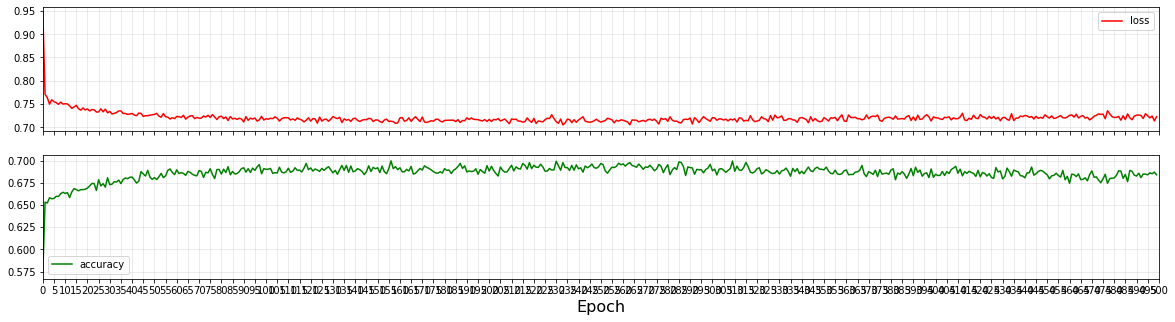

In [119]:
def plot_history(history, labels=['loss','accuracy']):
    """
    """
    
    metrics = [history[m] for m in labels]
    epochs = len(metrics[0])
    idx = range(0,epochs)
    colors = ['r','g','b','orange','magenta']
    
    fig,ax=plt.subplots(len(metrics),1, figsize=(20,5), sharex=True)
    for i in range(len(metrics)):
        ax[i].plot(idx,metrics[i],label=labels[i],c=colors[i])
        ax[i].grid(alpha=0.3)
        ax[i].legend()
    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_xlim(0,epochs)
    ax[i].set_xticks(range(0,epochs+5,5))
 
    plt.show()

# view dictionary element
hist = history.history
plot_history(hist)

La gráfica anterior muestra el progreso del loss y del accuracy del modelo con los datos del entrenamiento a medida que se ejecutan más epochs. Basados en esa gráfica, se determinó que no es necesario ejecutar 500 epochs, así que se volvió a ejecutar el modelo, pero esta vez con un límite de 120

In [120]:
model = Sequential()

model.add(Dense(18, kernel_initializer='normal', activation='relu', input_shape=(18,)))
model.add(Dropout(0.3))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.summary()

Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_740 (Dense)            (None, 18)                342       
_________________________________________________________________
dropout_29 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_741 (Dense)            (None, 14)                266       
_________________________________________________________________
dropout_30 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_742 (Dense)            (None, 10)                150       
_________________________________________________________________
dense_743 (Dense)            (None, 3)                 33        
Total params: 791
Trainable params: 791
Non-trainable params: 0
______________________________________________________

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [122]:
history = model.fit(X_train, y_train, epochs=120, batch_size=20, verbose=1)

Epoch 1/120
252/252 [==============================] - 1s 1ms/step - loss: 1.0294 - accuracy: 0.4680
Epoch 2/120
252/252 [==============================] - 0s 1ms/step - loss: 0.8299 - accuracy: 0.6492
Epoch 3/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7739 - accuracy: 0.6517
Epoch 4/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7774 - accuracy: 0.6419
Epoch 5/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7412 - accuracy: 0.6743
Epoch 6/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7535 - accuracy: 0.6534
Epoch 7/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7543 - accuracy: 0.6589
Epoch 8/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7537 - accuracy: 0.6580
Epoch 9/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7585 - accuracy: 0.6619
Epoch 10/120
252/252 [==============================] - 0s 1ms/step - loss: 0.7511 - accura

In [123]:
_, acc = model.evaluate(X_test, y_test)
print('Acc:')
print(acc)

46/46 [==============================] - 0s 819us/step - loss: 0.7765 - accuracy: 0.6344
Acc:
0.6344160437583923


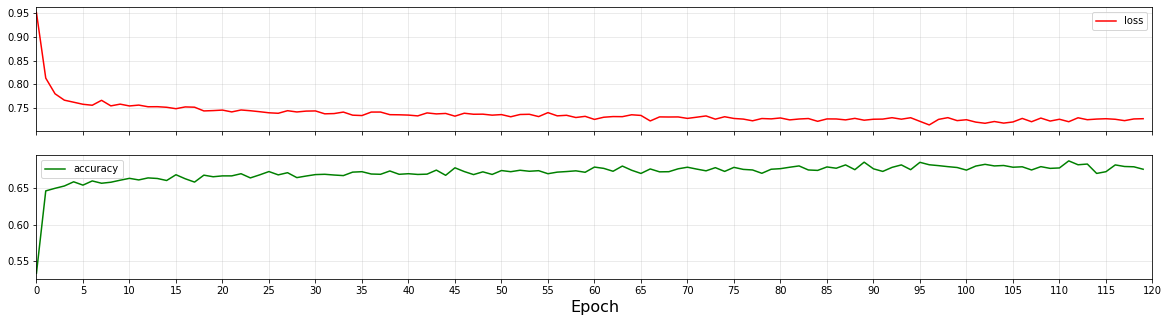

In [124]:
def plot_history(history, labels=['loss','accuracy']):
    """
    """
    
    metrics = [history[m] for m in labels]
    epochs = len(metrics[0])
    idx = range(0,epochs)
    colors = ['r','g','b','orange','magenta']
    
    fig,ax=plt.subplots(len(metrics),1, figsize=(20,5), sharex=True)
    for i in range(len(metrics)):
        ax[i].plot(idx,metrics[i],label=labels[i],c=colors[i])
        ax[i].grid(alpha=0.3)
        ax[i].legend()
    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_xlim(0,epochs)
    ax[i].set_xticks(range(0,epochs+5,5))
 
    plt.show()

# view dictionary element
hist = history.history
plot_history(hist)

In [125]:
_, acc = model.evaluate(X_val, y_val)
print('Acc:')
print(acc)

23/23 [==============================] - 0s 912us/step - loss: 0.7847 - accuracy: 0.6283
Acc:
0.6283310055732727


Este gráfico muestra un mejor trabajo del modelo, ya que no recorrió más epochs de los necesarios para alcanzar su máxima presición. 

Como ultimo paso, se realizó una predicción de los partidos disputados el 19 de Mayo de 2021. Hay que recordar que el objetivo del modelo es predecir resultados, situandonos en el medio tiempo. De esta forma conoceremos las estadísticas de juego al medio tiempo, lo cual otorga información vital para la predicción. A continuación se cargó el dataset llenado con la información de 5 partidos disputados el 19 de mayo. El resultado de la predicción será utilizado para apostar en la plataforma de BET365, y de esta forma pasar el modelo por la prueba de fuego. 

In [129]:
predecir = pd.read_csv("partidos_19.csv")
predecir.head()

,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,1,0,1,8,2,5,0,3.5,3.5,4,0,0,2,0,0,1.18,6.00,19.00
1,1,2,-1,1,8,1,4,7.0,6.5,0,1,1,0,0,0,1.55,4.50,5.25
2,0,1,-1,4,2,1,1,3.5,3.5,3,6,2,1,0,0,19.00,6.00,1.18
3,0,1,-1,4,12,1,1,5.0,3.5,2,2,0,0,0,0,9.00,6.00,1.28
4,1,1,0,7,9,3,3,4.0,5.5,4,5,2,1,0,0,5.25,4.33,1.57


In [130]:
scaler = StandardScaler().fit(predecir)

predecir = scaler.transform(predecir)

In [131]:
predicciones = predecir

pred = model.predict(predecir)
pred = np.around(pred, 2)
pred

array([[0.  , 0.  , 1.  ],
       [0.66, 0.27, 0.07],
       [0.65, 0.27, 0.09],
       [0.57, 0.31, 0.11],
       [0.15, 0.34, 0.51]], dtype=float32)

Al tener una variable objetivo con 3 categorías, el modelo predictivo retorna un array donde cada fila tiene 3 valores. El valor más alto será el que se tome como la predicción del modelo.

Se generó la siguiente función para convertir el output de la predicción del modelo a una forma fácil de interpretar por el usuario, la cual es una lista que muestra el resultado de cada partido predecido.

In [132]:
def predecir(pred):
    resultados=[]
    for i in range(pred.shape[0]):
            if ((pred[i,0] > pred[i,1]) & (pred[i,0] > pred[i,2])):
               resultados.append('AWAY')
            elif(pred[i,1] > pred[i,2]):
               resulatos.append('DRAW')
            else:
               resultados.append('HOME')
    return(resultados)               

In [133]:
resultados = predecir(pred)
resultados

['HOME', 'AWAY', 'AWAY', 'AWAY', 'HOME']

Como se observa en la lista, el modelo predijo los 5 resultados. Tras replicarlos en la plataforma de bet365, resulto ser que el modelo acerto 4 de las 5 predicciones. Esta cifra no esta mal, y de hecho esta por encima del valor esperado debido a su accuracy. El modelo fue capaz de obtener una ganancia neta de $0.10, con una apuesta de $1, es decir el 10% de ganacia. Esto me deja muy satisfecho, sin embargo soy conciente de que si se hubiese dado el valor esperado de aciertos, el resultado neto hubiera sido perdida. 

# CONCLUSIONES

Si consideramos las métricas obtenidas por el modelo (accuracy en train de 0.69, test de 0.64 y cross validation de 0.63) no suenan muy altas. Sin embargo, cabe mencionar que el dataset utilizado no era el más grande, y su informació era tambien dificil de aprovechar completamente. El dataset sufrío algunas transformacones para adptarse a las apuestas al medio tiempo (como tener que dividir las estadisticas del partido a la mitad), y aun así conservó la capacidad de predecir un 63% de las predicciones intentadas con el modelo de redes neurales. Adicionalmente tengo que decir que aunque me hubiera gustado obtener un accuracy más alto, si el fútbol fuera tan fácil de predecir, no sería fútbol. Probablemente estamos acostumbrados a fenomenos de la vida real que pueden ser muy estimables por modelos de machine learning, pero sin embargo queda claro que el fútbol, al menos con un set de datos como el que se utilizó para este proyecto, no puede ser predecido con la exactitud deseada. Sin embargo, un enfoque muy positivo es que el proyecto fue capaz de obtener ganancia neta despues de ser usado en 5 apuestas. 

## Referencias:                                                                                              

Grid Search Deep Learning Model Parameters: uso de un grid search, para probar multiples hiper parámetros, y definir cual era la mejor combinación sobre la cual seguir desarrollando el modelo. Fuente: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

Criterio para generar la arquitectura más apropiada para la red neuronal que entrenaría el módelo final. Fuente: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

Criterio para decidir si normalizar o estandarizar los datos, dependiendo de lo que se busca. Fuente: http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html